# Phase 2: Classification Prediction with Imbalanced Target

# Mary Donovan Martello

**Phase 1 of the credit card default project involved testing five binary classification models for predicting credit card defaults.  Phase 1 can be found:** [here](https://github.com/MaryDonovanMartello/Credit-Card-Default-Prediction)

**Phase 2 of the credit card default project includes (1) employing methodologies other than Principal Component Analysis to address multicollinearity and feature selection in an effort to be able to analyze individual factors that are significant for defaults, (2) testing multiple approaches to addressing an imbalanced target variable in a binary classification model, and (3) implementing deployment models to make actual predictions and convert the logistic regression coefficients to a risk score that can be used in making lending decisions.**

## Part 4:  Approach to Imbalanced Target:  Oversample Training with Holdout Method

In [2]:
# import libraries

import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax
from numpy import where

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, recall_score, average_precision_score, auc, precision_recall_curve, log_loss

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import BorderlineSMOTE
# from imblearn.over_sampling import SVMSMOTE
# from imblearn.over_sampling import ADASYN
# from imblearn.pipeline import Pipeline


#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')




### This notebook uses two datasets that were cleaned and prepared in the 1_EDA_Prep notebook.  One of the datasets replaces some of the original variables with the Months_Late engineered features and the second dataset replaces some of the original variables with both the Months_Late and Payment_Ratio engineered features.

In [3]:
# Load data into a dataframe

df1 = pd.read_csv('logDefaultRev1.csv')
df2 = pd.read_csv('logDefaultRev2.csv')

In [4]:
df1.head()

,default,SEX,EDUCATION,MARRIAGE,AGE,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MONTHS_LATE
0,1,1,1,2,3.401197,10.819798,12.157764,11.451880,12.121908,12.185186,11.599122,12.815479,0.000000,7.901377,0.000000,7.707962,7.090910,0.000000,1.94591
1,1,1,2,2,3.401197,12.676079,12.318723,11.767754,12.289720,12.339830,11.875079,12.907014,7.824446,7.824446,0.000000,8.476580,7.783641,7.378384,1.94591
2,1,1,1,1,3.988984,12.206078,12.623996,12.257488,12.610621,12.657464,12.339112,13.100394,8.748464,8.612685,8.612685,8.612685,8.517393,8.517393,1.94591
3,0,2,2,2,3.295837,11.002117,12.311630,11.735957,12.285069,12.346786,11.826144,12.886411,0.000000,8.517393,7.828835,1.945910,8.006701,8.006701,1.94591
4,0,1,2,1,3.737670,12.542548,12.615709,12.246783,12.584776,12.658428,12.360976,13.100157,8.779711,0.000000,9.564863,9.605822,0.000000,8.517393,1.94591


In [6]:
df1.shape

(30000, 19)

In [7]:
df1.columns

Index(['default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'MONTHS_LATE'],
      dtype='object')

In [8]:
df2.head()

,default,SEX,EDUCATION,MARRIAGE,AGE,LIMIT_BAL,MONTHS_LATE,PAYMENT_RATIO
0,1,1,1,2,3.401197,10.819798,1.94591,0.038110
1,1,1,2,2,3.401197,12.676079,1.94591,0.037397
2,1,1,1,1,3.988984,12.206078,1.94591,0.037338
3,0,2,2,2,3.295837,11.002117,1.94591,0.038758
4,0,1,2,1,3.737670,12.542548,1.94591,0.046396


In [9]:
df2.shape

(29130, 8)

In [10]:
df2.columns

Index(['default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL',
       'MONTHS_LATE', 'PAYMENT_RATIO'],
      dtype='object')

**Create feature dataframes for modeling.**

In [11]:
#df1

# separate into input and output columns (X variable for features and y for target variables)

X1 = df1.drop('default', axis = 1) 
y1 = df1['default']

In [12]:
y1.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [42]:
#df1 subset

# separate into input and output columns (X variable for features and y for target variables)

X1s = df1.loc[:, ['MONTHS_LATE', 'LIMIT_BAL', 'AGE']] 
y1s = df1['default']

In [13]:
#df1

# one-hot encode input categorical variables
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0, 1, 2])], remainder='passthrough')
X1 = transformer.fit_transform(X1)


In [15]:
#df2

# separate into input and output columns (X variable for features and y for target variables)

X2 = df2.drop('default', axis = 1) 
y2 = df2['default']

In [16]:
y2.value_counts()

0    22811
1     6319
Name: default, dtype: int64

In [17]:
X2.columns

Index(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL', 'MONTHS_LATE',
       'PAYMENT_RATIO'],
      dtype='object')

In [18]:
#df2

# one-hot encode input categorical variables

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0, 1, 2])], remainder='passthrough')
X2 = transformer.fit_transform(X2)


In [43]:
#df2 subset

# separate into input and output columns (X variable for features and y for target variables)

X2s = df2.loc[:, ['MONTHS_LATE', 'PAYMENT_RATIO',]] 
y2s = df2['default']

**Split and scale data**

In [19]:
# separate data into training and test data
X1Train, X1Test, y1Train, y1Test = train_test_split(X1, y1, test_size =0.2, random_state=1)

# define the scaler
scaler = StandardScaler()
# fit and transform on the training dataset
X1Train = scaler.fit_transform(X1Train)
# transform the test dataset
X1Test = scaler.transform(X1Test)

In [35]:
# separate data into training and test data
X2Train, X2Test, y2Train, y2Test = train_test_split(X2, y2, test_size =0.2, random_state=1)

# define the scaler
scaler2 = StandardScaler()
# fit and transform on the training dataset
X2Train = scaler.fit_transform(X2Train)
# transform the test dataset
X2Test = scaler.transform(X2Test)

In [44]:
# separate data into training and test data
X1sTrain, X1sTest, y1sTrain, y1sTest = train_test_split(X1s, y1s, test_size =0.2, random_state=1)

# define the scaler
scaler1s = StandardScaler()
# fit and transform on the training dataset
X1sTrain = scaler.fit_transform(X1sTrain)
# transform the test dataset
X1sTest = scaler.transform(X1sTest)

In [45]:
# separate data into training and test data
X2sTrain, X2sTest, y2sTrain, y2sTest = train_test_split(X2s, y2s, test_size =0.2, random_state=1)

# define the scaler
scaler2s = StandardScaler()
# fit and transform on the training dataset
X2sTrain = scaler.fit_transform(X2sTrain)
# transform the test dataset
X2sTest = scaler.transform(X2sTest)

**Look at target imbalance**

In [20]:
y1Train.value_counts()

0    18705
1     5295
Name: default, dtype: int64

In [36]:
y2Train.value_counts()

0    18231
1     5073
Name: default, dtype: int64

**Oversample Training Data**

In [22]:
# over sample the minority class
#from imblearn.over_sampling import SMOTE

smote = SMOTE()
X1TrainBal, y1TrainBal = smote.fit_resample(X1Train, y1Train)

In [23]:
# new balance
yPosClass = np.count_nonzero(y1TrainBal==1)
print(yPosClass)

18705


In [24]:
yNegClass = np.count_nonzero(y1TrainBal==0)
print(yNegClass)

18705


In [37]:
X2TrainBal, y2TrainBal = smote.fit_resample(X2Train, y2Train)

In [46]:
X1sTrainBal, y1sTrainBal = smote.fit_resample(X1sTrain, y1sTrain)

In [47]:
X2sTrainBal, y2sTrainBal = smote.fit_resample(X2sTrain, y2sTrain)

**Gridsearch to tune Logistic Regression model**

In [25]:
params = {'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l1', 'l2']}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

lr_grid = GridSearchCV(LogisticRegression(),
                       param_grid=params,
                       scoring={'avr': make_scorer(recall_score, needs_proba=False),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
                       n_jobs=-1,
                       cv=skf,
                       refit='avr')

**Fit the oversampled training data**

Duplicate for each of four subsets of data.

In [27]:
#X1 df
lr_grid.fit(X1TrainBal, y1TrainBal)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=0)

In [38]:
#X2 df
lr_grid.fit(X2TrainBal, y2TrainBal)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=0)

In [48]:
#X1s df
lr_grid.fit(X1sTrainBal, y1sTrainBal)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=0)

In [52]:
#X2s df
lr_grid.fit(X2sTrainBal, y2sTrainBal)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=0)

In [68]:
# save the model to a file
#import joblib
filename = 'TrainTest1model.sav'  
joblib.dump(lr_grid, filename)

['TrainTest1model.sav']

**Evaluate Predictions**

<AxesSubplot:>

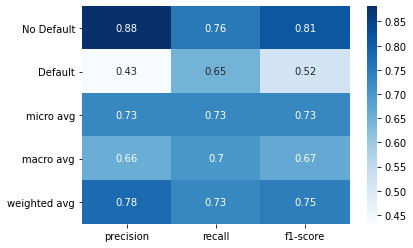

In [29]:
# predictions X1 df
y1Pred = lr_grid.predict(X1Test)

lrCR = classification_report(y1Test, y1Pred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(lrCR).iloc[:-1, :].T, annot=True, cmap="Blues")

In [30]:
print(lrCR)

{'No Default': {'precision': 0.8812625250501002, 'recall': 0.755097660442155, 'f1-score': 0.8133163796092938, 'support': 4659}, 'Default': {'precision': 0.43177290836653387, 'recall': 0.6465324384787472, 'f1-score': 0.517766497461929, 'support': 1341}, 'micro avg': {'precision': 0.7308333333333333, 'recall': 0.7308333333333333, 'f1-score': 0.7308333333333333, 'support': 6000}, 'macro avg': {'precision': 0.656517716708317, 'recall': 0.700815049460451, 'f1-score': 0.6655414385356114, 'support': 6000}, 'weighted avg': {'precision': 0.780801595721323, 'recall': 0.7308333333333333, 'f1-score': 0.7472609809493577, 'support': 6000}}


<AxesSubplot:>

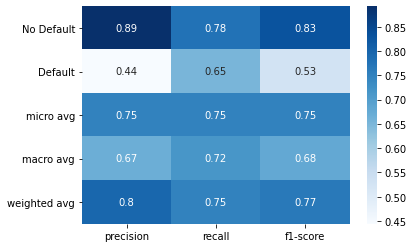

In [40]:
# predictions X2
y2Pred = lr_grid.predict(X2Test)

lrCR2 = classification_report(y2Test, y2Pred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(lrCR2).iloc[:-1, :].T, annot=True, cmap="Blues")

In [41]:
lrCR2

{'No Default': {'precision': 0.8920340681362725,
  'recall': 0.7775109170305677,
  'f1-score': 0.8308446103593095,
  'support': 4580},
 'Default': {'precision': 0.44438386041439476,
  'recall': 0.6540930979133226,
  'f1-score': 0.5292207792207793,
  'support': 1246},
 'micro avg': {'precision': 0.7511156882938551,
  'recall': 0.7511156882938551,
  'f1-score': 0.7511156882938551,
  'support': 5826},
 'macro avg': {'precision': 0.6682089642753336,
  'recall': 0.7158020074719451,
  'f1-score': 0.6800326947900444,
  'support': 5826},
 'weighted avg': {'precision': 0.7962956268692867,
  'recall': 0.7511156882938551,
  'f1-score': 0.7663366643245328,
  'support': 5826}}

<AxesSubplot:>

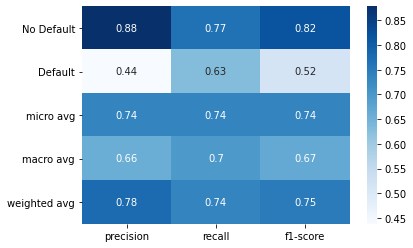

In [50]:
# predictions X1s subset
y1sPred = lr_grid.predict(X1sTest)

lrCR1s = classification_report(y1sTest, y1sPred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(lrCR1s).iloc[:-1, :].T, annot=True, cmap="Blues")

In [51]:
lrCR1s

{'No Default': {'precision': 0.8783484885721308,
  'recall': 0.7671174071689204,
  'f1-score': 0.8189734188817599,
  'support': 4659},
 'Default': {'precision': 0.43811496633868463,
  'recall': 0.6308724832214765,
  'f1-score': 0.5171149144254279,
  'support': 1341},
 'micro avg': {'precision': 0.7366666666666667,
  'recall': 0.7366666666666667,
  'f1-score': 0.7366666666666667,
  'support': 6000},
 'macro avg': {'precision': 0.6582317274554077,
  'recall': 0.6989949451951984,
  'f1-score': 0.6680441666535939,
  'support': 6000},
 'weighted avg': {'precision': 0.7799562963529555,
  'recall': 0.7366666666666667,
  'f1-score': 0.7515080431357698,
  'support': 6000}}

<AxesSubplot:>

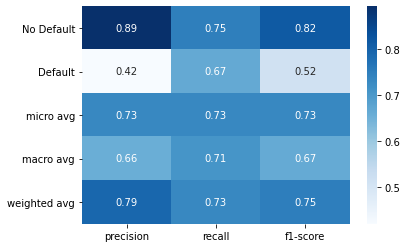

In [54]:
# predictions X2s subset
y2sPred = lr_grid.predict(X2sTest)

lrCR2s = classification_report(y2sTest, y2sPred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(lrCR2s).iloc[:-1, :].T, annot=True, cmap="Blues")

In [55]:
lrCR2s

{'No Default': {'precision': 0.8924675324675325,
  'recall': 0.7502183406113537,
  'f1-score': 0.8151838671411625,
  'support': 4580},
 'Default': {'precision': 0.42105263157894735,
  'recall': 0.6677367576243981,
  'f1-score': 0.516449410304159,
  'support': 1246},
 'micro avg': {'precision': 0.7325780981805698,
  'recall': 0.7325780981805698,
  'f1-score': 0.7325780981805697,
  'support': 5826},
 'macro avg': {'precision': 0.65676008202324,
  'recall': 0.7089775491178759,
  'f1-score': 0.6658166387226607,
  'support': 5826},
 'weighted avg': {'precision': 0.7916465632764619,
  'recall': 0.7325780981805698,
  'f1-score': 0.7512938683050989,
  'support': 5826}}